In [1]:
import argparse
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import os
from pathlib import Path
from time import sleep
from random import random
from multiprocessing import Pool
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.ops import transform
from descartes import PolygonPatch
import networkx as nx
from mpl_toolkits import mplot3d
import settings
import base as cylinder
import copy
import math
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'

In [3]:
#StemPath Class
#DIR = settings.DIRimport geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import logging
import settings
import os
from pathlib import Path
from time import sleep
from random import random
from multiprocessing import Pool
from shapely.geometry import Polygon
from shapely.ops import unary_union
from descartes import PolygonPatch
import networkx as nx
from mpl_toolkits import mplot3d
from pickle import dump, load

import calendar
import time

current_GMT = time.gmtime()
time_stamp = str(calendar.timegm(current_GMT))

#NAME = Cylinder
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'
#DIR = settings.DIR
logging.basicConfig(filename=''.join(['log_',str(time_stamp)])  , filemode='w', level=logging.DEBUG)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))
log = logging.getLogger("my-logger")

class StemPath:
    
    #initialize our object level variables for cylider objects 
    #initialize our object level variables for cylider objects 
    def __init__(self,filename) -> None:
        self.filename = filename
        self.nodes =  []
        self.cyls =  CylinderCollection()
        self.graph = nx.DiGraph()
        self.tLength = np.nan
        self.maxBO = np.nan
        self.angles = []
        self.heights = []
        self.attr_dict = []
        self.projected_surface_area = np.nan
        self.branch_grps = []

    def load_path(self):
        return np.nan
    
    def identify_drip_points(self):
        for n in self.nodes:
            print(self.graph.edges[n])

    def get_cyl_data(gr, ):
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True

        #sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
        sp = nx.shortest_path(gr,target=0, weight ='get_height')
        #print([e for e in gr.nodes if gr.degree(e)==1])
        endnodes = [e for e in gr.nodes if gr.degree(e)==1]
        color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
        #print(len(endnodes))


        #print(gr.edges[1,0]['attr_dict']['eheight'])
        for path in sp.values():
            pathLen = len(path)
            #x =np.arange(0,pathLen-1)
            c = next(color)
            if (path[0] in endnodes)and pathLen>2:
                s = stemPath()
                fig, ax = plt.subplots()
                heights = []
                for idx,v in enumerate(path):
                    if idx+1!=pathLen:
                        u = path[idx+1]
                        heights.append( gr.edges[v,u]['attr_dict']['eheight'])
                ax.plot(heights,color= c, label = str(path[0]))
        plt.show()              

In [2]:
#Read_file_names
def read_file_names():
    os.chdir(''.join([DIR,'input']))
    fullPath = Path(''.join([DIR,'input']))
    paths = sorted(fullPath.iterdir(),key=os.path.getmtime)
    fileNames = [f.name for f in paths if  f.suffix == '.csv' ]
    print(fileNames)
    return fileNames

In [9]:
#CC class
import geopandas as geo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import logging
import settings
import os
from pathlib import Path
from time import sleep
from random import random
from multiprocessing import Pool
from shapely.geometry import Polygon
from shapely.ops import unary_union
from descartes import PolygonPatch
import networkx as nx
from mpl_toolkits import mplot3d
from pickle import dump, load
from stemPath import StemPath

import calendar
import time
import copy

current_GMT = time.gmtime()
time_stamp = str(calendar.timegm(current_GMT))

NAME = "Cylinder"
DIR= r'C:/Users/wisch/Documents/GitProjects/cylinders_personal/'
#DIR = settings.DIR
logging.basicConfig(filename=''.join(['log_',str(time_stamp)])  , filemode='w', level=logging.DEBUG)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))
log = logging.getLogger("my-logger")
#suggested libraries 
#import pytest as pt
#import logging as log # replace writes to the console with various logging 
class CylinderCollection:
    
    #initialize our object level variables for cylider objects 
    def __init__(self, filename) -> None:
        self.filename = filename
        self.z = np.nan
        self.y = np.nan
        self.z = np.nan
        self.radius = np.nan
        self.noCylinders = np.nan
        self.cLength = np.nan
        self.BO = np.nan
        self.maxBO = np.nan
        self.dx = np.nan
        self.dy = np.nan
        self.dz = np.nan
        self.theta = np.nan
        self.pID = np.nan
        self.pSV = []
        self.df_full = pd.DataFrame()
        self.df = pd.DataFrame()
        self.total_union = None
        self.stem_path_lengths = np.nan
        self.graph = nx.Graph()
        self.polyparts = []
        self.bID = np.nan
        self.stem_paths =  []
        self.dripPoints = []
        self.aV=pd.DataFrame()
        self.bV=pd.DataFrame()
        self.stemPaths=pd.DataFrame()
        self.flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
        self.flow_to_drip = {0:1} # A dictionary of flow ids with values equal to their drip node ids 
        self.trunkNodes = []

    #potential additional functions 

    #def cylinderUnion(T,chunkSize,itCount): 
    #    return np.nan

    #def
    #def
    #def
    #def
    def pickle_save(graph, name, path=''.join([DIR,'output/graphs/'])):
        nx.write_gpickle(graph, open(path + name, 'wb'))
    
    def load_stem_paths(self):  
        self.stempaths = np.load(''.join([DIR,'output/stems/',str(self.filename),'.npy']))

    def load_graph(self):
        gname =  str(''.join([DIR,'output/graphs/', self.filename.replace('.csv','.txt')]))
        with open(gname, 'rb') as file :
            self.graph = nx.read_gpickle(gname)
    # def pickle_load(fullpath,test):
    #     with open(fullpath, 'rb') as file :
    #         gr = nx.read_gpickle(file)
    #     return gr
 
    def read_csv(self,df = pd.DataFrame(), polys = []):
        #Columns [ID?,ParentID?,x1,y1,z1,x2,y2,z2,radius,?,?,lenght,? ,? ,? ,? ,? ,? ,? ,BO]
        #Colnums [1  ,2        ,3 , 4, 5, 6, 7, 8,9    ,10,11,12   ,13,14,15,16,17,18,19,20]
        # x = x2-x1, y =y2-y1, z=z2-z1
        #number of cyliders = cnt values for radius
        # Theta  = angle made buy the cylinder axis
        if('partial' not in self.filename):
            self.df_full = pd.read_csv(self.filename,header=0)
        else: 
            self.df_full = df
        self.maxBO = np.max(self.BO)
        #self.df = self.df_full 
        self.df=self.df_full#.iloc[:130,:]
        self.x = np.transpose(self.df.iloc[:,[3,6]].to_numpy())#columns 3 and 6 represent our x values
        self.y = np.transpose(self.df.iloc[:,[4,7]].to_numpy())#columns 4 and 7 the y values 
        self.z = np.transpose(self.df.iloc[:,[5,8]].to_numpy())#columns 5 and 8 the z values 
        # for side view
        #self.z = np.transpose(self.df.iloc[:,[4,7]].to_numpy())#columns 4 and 7 the y values 
        #self.y = np.transpose(self.df.iloc[:,[5,8]].to_numpy())#columns 5 and 8 the z values 
        self.pID =self.df.iloc[:,2].to_numpy()
        self.radius = self.df.iloc[:,9].to_numpy()
        self.noCylinders = self.radius.size
        self.cLength = self.df.iloc[:,12].to_numpy()
        self.BO = self.df.iloc[:,20].to_numpy()
        self.maxBO = np.max(self.BO)
        self.bID = self.df.iloc[:,24].to_numpy()
        self.dx = self.df.iloc[:,6].to_numpy() - self.df.iloc[:,3].to_numpy()
        self.dy = self.df.iloc[:,7].to_numpy() - self.df.iloc[:,4].to_numpy()
        self.dz = self.df.iloc[:,8].to_numpy() - self.df.iloc[:,5].to_numpy()
        if('partial' in self.filename): self.pSV = polys
        self.theta = np.arctan(self.dz/np.sqrt(self.dx**2 + self.dy**2))
        log.info(self.filename + " initialized")
    
    def create_wdgraph(self):
        R = {}
        sid = self.df[' ID']
        pid = self.df[' parentID']
        sid.min()
        sid = sid + 1
        pid = pid + 1

        noSeg = np.max(sid) + 2
        A = np.zeros((noSeg,noSeg))
        
        #color = iter(cm.rainbow(np.linspace(0, 1, noSeg)))
        
        attr = []
        gr = nx.Graph()
        for idx in range(noSeg-3):
            #from row to column
            child =sid[idx]
            par = pid[idx]
            # attr={"length" : self.df.iloc[pid[idx], 12],
            #         "bheight": self.df.iloc[pid[idx], 5],
            #         "eheight": self.df.iloc[pid[idx], 8],
            #         "radius": self.df.iloc[pid[idx], 9],
            #         "aV": self.aV[pid[idx]],
            #         "bV": self.bV[pid[idx]],
            #         "bV": self.bV[pid[idx]]
            #         }
            gr.add_edge(child,par,length= self.df.iloc[sid[idx]-1, 12],
                                  bheight= self.df.iloc[sid[idx]-1, 5],
                                  eheight= self.df.iloc[sid[idx]-1, 8],
                                  radius= self.df.iloc[sid[idx]-1, 9],
                                  aV= self.aV[sid[idx]-1],
                                  poly= self.pSV[sid[idx]-1],
                                  inFlow= self.dz[sid[idx]-1] > 0 ) # if z2-z1 > 0 then flow goes towards trunk 
        self.graph = gr

    #its pro-ject not prah-ject
    def project_cylinders(self):
        log.info(self.filename + " cylinder projection begun")
        noCirPoints = 360

        tCir = np.linspace(0,2*np.pi,noCirPoints) #360 evenly spaced points between 0 - 2pi (radian degrees)

        XOrtho = np.cos(tCir)
        YOrtho = np.sin(tCir)

        #unit vector at base of cylinder, pointing up cylinder axis
        vNorm = (np.sqrt(self.dx**2+self.dy**2+self.dz**2))
        aV = np.hstack((self.dx[:,None],self.dy[:,None],self.dz[:,None]))/vNorm[:,None]
        bV = -aV; #unit vector looking down from top circle (but not translated)
        self.aV = aV
        self.bV = bV
        #function to find orthgonal vectors
        oVz = lambda v,x,y : ((-v[0]*x - v[1]*y)/v[2])

        #initializing min max arrays+
        minZ = np.zeros_like(self.dz)
        maxZ = np.zeros_like(self.dz)

        pSV = [None]*self.noCylinders

        #for each cylinder
        for idx in range(self.noCylinders):

            #in the case there's no horizontal movement of the cylinder ends, it's
            #area is a circle.
            if not np.isnan(self.x[0,idx]):
                if np.logical_and(self.dx[idx] == 0, self.dy[idx] == 0):
            
                    pX = self.x[0,idx] + self.radius[idx]*XOrtho
                    pY = self.y[0,idx] + self.radius[idx]*YOrtho
                    cPS = Polygon(list(zip(pX,pY)))
                    minZ[idx] = np.min(self.z[:,idx])
                    maxZ[idx] = np.max(self.z[:,idx])
                else:
                    #find orthogonal vectors @ endpoints
                    aVp1 = np.hstack((aV[idx,1],-aV[idx,0]))
                    aVp2 = np.hstack((-aV[idx,1],aV[idx,0]))
                    bVp1 = np.hstack((bV[idx,1],-bV[idx,0]))
                    bVp2 = np.hstack((-bV[idx,1],bV[idx,0]))
                
                    aVp1 = aVp1/np.linalg.norm(aVp1)
                    aVp2 = aVp2/np.linalg.norm(aVp2)
                    bVp1 = bVp1/np.linalg.norm(bVp1)
                    bVp2 = bVp2/np.linalg.norm(bVp2)
                
                    #from each endpoint, use radius to find vertices of the rectangle
                    x1 = self.x[0,idx] + self.radius[idx]*aVp1[0]
                    y1 = self.y[0,idx] + self.radius[idx]*aVp1[1]
                    x2 = self.x[0,idx] + self.radius[idx]*aVp2[0]
                    y2 = self.y[0,idx] + self.radius[idx]*aVp2[1]  
                    x3 = self.x[1,idx] + self.radius[idx]*bVp1[0]
                    y3 = self.y[1,idx] + self.radius[idx]*bVp1[1]
                    x4 = self.x[1,idx] + self.radius[idx]*bVp2[0]
                    y4 = self.y[1,idx] + self.radius[idx]*bVp2[1]
            
            
                    #calculate set of orthgonal vectors using lambda function
                    ZOrtho = oVz(aV[idx,:],XOrtho,YOrtho)
                
                    #unit-ify the orthgonal vectors
                    uovd = np.sqrt(XOrtho**2 + YOrtho**2 + ZOrtho**2)
                    uov = np.hstack((XOrtho[:,None],YOrtho[:,None],ZOrtho[:,None]))/uovd[:,None]
            
                    #donot re unit-fy, you only want the horizontal component, not the
                    #renormalized horizontal component
                
                    #using only the X and Y components, find circle coods in plane of
                    #interest
                    xaC = self.x[0,idx] + uov[:,0]*self.radius[idx]
                    yaC = self.y[0,idx] + uov[:,1]*self.radius[idx]
                    zaC = self.z[0,idx] + uov[:,2]*self.radius[idx]
            
                    xbC = self.x[1,idx] + uov[:,0]*self.radius[idx]
                    ybC = self.y[1,idx] + uov[:,1]*self.radius[idx]
                    zbC = self.z[1,idx] + uov[:,2]*self.radius[idx]
            
                    minZ[idx] = np.min(np.vstack((zaC, zbC)))
                    maxZ[idx] = np.max(np.vstack((zaC, zbC)))
                
                    #assymble total package
                    rX = np.vstack((x1, x2, x3, x4))
                    rY = np.vstack((y1, y2, y3, y4))
            
                    #test for circle parts in polygon
                    c1 = Polygon(list(zip(xaC,yaC)))
                    bBox = Polygon(list(zip(rX,rY)))
                    c2 = Polygon(list(zip(xbC,ybC)))           
                    partsPS = [c1,bBox,c2]
            
                    try: 
                        cPS = unary_union(partsPS)
                    except:
                        print(np.any(np.isnan(xaC)))
                        print(yaC)
                        print(rX)
                        print(rY)
                        print(xbC)
                        print(ybC)
                #cPS = cPS.simplify(0.02,preserve_topology=False)               
                self.pSV.append(cPS) #save polygon
                            
                #print a progress update once every 10 thousand or so cylinders
                if np.random.uniform(0,1,1) < 0.0001:
                    log.info(self.filename + ': completed {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))
                    print('completed {} \n'.format(np.round((idx/self.noCylinders)*100,decimals=1)))

    def highlight_branch_order(self, bo):
        trunk_ids = []
        colors = ['']*len(self.pSV)
        rev_polys =['']*len(self.pSV)
        for idx, bo_i in enumerate(self.BO):
            if bo_i == bo: 
                trunk_ids.append(idx)
                colors[-idx] = 'Red'
                #polys.append(c.pSV[idx])
            else:
                colors[-idx] ='None'
            rev_polys[-idx] = self.pSV[idx]

        fig, ax = plt.subplots(figsize = (20,16)) 
        myPolys = geo.GeoSeries(rev_polys)
        myPolys.plot(color=colors,ax=ax, alpha = .5)
        plt.savefig(str(self.filename).replace('.csv','') +str("BO_highlight_XY.svg"), format='svg', dpi=1200)     
        plt.ion()
        plt.show()        

    
    def find_flows(self):
        c= self
        g = c.graph  
        trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1 as cyl 0 has parent -1 
        self.trunkNodes=trunkNodes 
        gtest = copy.deepcopy(g)
        #Set attributes used to mark drip point and flows
        nx.set_edge_attributes(g, np.nan, 'flowType') 
        nx.set_edge_attributes(g, np.nan, 'flowID')
        nx.set_edge_attributes(g, np.nan, 'dripNode')
        nx.set_node_attributes(g, np.nan, 'isDripPoint')
        nx.set_node_attributes(g, np.nan, 'isDividePoint')
        #function to get angles of unit vectors 
        get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])  
        flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
        trunk_flow = pd.DataFrame({'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
        flows = pd.concat([flows, trunk_flow], ignore_index=True)
        prev_node = None
        trunk_edges = []
        for n in trunkNodes:
            if prev_node !=None:
                trunk_edges.append((prev_node,n))
            prev_node = n
        for te in trunk_edges:
            g.edges[te]['flowID'] = 0
            g.edges[te]['flowType'] = 'stem'  
        non_trunk_edges = [e for e in g.edges(trunkNodes) if e not in trunk_edges]
        #print(gtest.number_of_nodes())    
        gtest.remove_nodes_from(trunkNodes)  
        gtest.add_edges_from(non_trunk_edges)   
        #print(nx.number_connected_components(gtest))
        titans = [node for node in gtest.nodes if (nx.degree(g,node)!=nx.degree(gtest,node))]
            #Nodes with a parent node in trunk, only 1 per connected component
        c.connComps = nx.connected_components(gtest)
        compGraphs = [g.subgraph(comp).copy() for comp in c.connComps]
        #
        flow_to_drip = { 0:1 }# flow_path_id:node_id; the flow on the trunk is always flow_path_id 0 and has drip point node 1
        # if 1==1:
            # compGraph = compGraphs[16]# for testing
            # test = True
        for comp_id,compGraph in enumerate(compGraphs): #suenumerate(c.connComps):
            test = False
            if test : print('comp_id: '+str(comp_id))
            #compGraph = g.bgraph(comp).copy()
            nodes = compGraph.nodes()
            # myPolys = []
            # for n in nodes:
            #     myPolys.append(c.pSV[n-1])
            
            endnodes = [e for e in compGraph.nodes if compGraph.degree(e)==1]
            root =list(set(titans) & set(compGraph.nodes)) #get root of connected component
            if root[0] in endnodes: endnodes.remove(root[0])
            sp = nx.shortest_path(compGraph,target=root[0])
            sp_endNode_paths = [path for path in sp.values() if path[0] in endnodes]
            # stem flow is always id 0
            # print('stem flow added :' + str(flows))
            #arrays we are using are all unit arrays and we want angles with x,y and z ([1,0,0],[0,1,0] and [0,0,1])
            # display(flows)
            for path in sp_endNode_paths:
                # print('path ' + str( path))
                traversedEdges = []
                flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                    }, index = [0])
                angleSum=0
                angles = [0,0,0]
                prev_angles = [0,0,0]
                current_dp_node = 0
                if test : print(path)
                for idx,n in enumerate(path):  
                    if test : print('Entering path Loop ' + str(idx) + ' for node '  + str(n) + ' next node ' + str(path[idx+1])) 
                    if test : print('dtf: '+str(flow_to_drip))
                    if test : print('next node '  + str(path[idx+1])) 
                    if test : print('current_dp_node'  + str(current_dp_node)) 
                    node_id = n
                    next_node_id  = path[idx+1]
                    node = g.nodes[node_id]
                    next_node =  g.nodes[next_node_id]
                    edge = g.edges[node_id,next_node_id]
                    if test : print('edge[''inFlow''] '  + str(edge['inFlow'])) 
                    if test : print('edge[''len''] '  + str(edge['length'])) 
                    curr_angles = get_angle_array(edge['aV'])
                    angleSum += curr_angles.iloc[3]  
                    traversedEdges.append((node_id,next_node_id)) # add node to list of nodes in this path 
                    flow['cyls']+=1
                    flow['len'] +=edge['length']
                    flow['sa'] +=2*np.pi*edge['radius']*(edge['radius'] +edge['length'])
                    flow['pa'] +=edge['poly'].area
                    if test : print('flow: ' + str(flow))
                    if test : print('flows: ' + str(flows))
                    if idx+2==len(path):
                        # print('last run entered')
                        #then path[idx+1] is the root node -> edge is last edge
                        if current_dp_node!= 0:
                            if edge['inFlow']:
                                #not possible as we would have had to set current_dp_node last loop 
                                # we would onlt do so if this edge had out flow
                                if test : print('Error: Reached last edge and edge has inflow and is in drip path')
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + 'stem')
                                flow_to_drip[flow_id] =current_dp_node
                                traversedEdges = [] # reset array'
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                break
                            #Then we are on a drip path 
                            elif ~edge['inFlow']:
                                #then we do indeed add this last cyl to the drip flow
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + ' marked ' + str(flowType))
                                flow_to_drip[flow_id] =current_dp_node
                                if test : print('path.index(current_dp_node): ' + str(path.index(current_dp_node)))
                                if test : print('pathLen ' + str(len(path)))
                                if test : print('current_dp_node: ' + str(current_dp_node))
                                traversedEdges = [] # reset array'
                                current_dp_node = 0
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                if test : print('New drip Flow Created (last node ) ' +str(flow_id))
                                break
                        elif edge['inFlow']: #must be the case given current_dp_node ==0
                            # edge contribures to stem flow 
                            if test : print('flow to add: '+str(flow))
                            flows = pd.concat([flows, flow], ignore_index=True)
                            flow_id = len(flows.index)-1
                            for traversedEdge in traversedEdges: 
                                g.edges[traversedEdge]['flowID'] = flow_id
                                g.edges[traversedEdge]['flowType'] = 'stem'
                                if test : print(str(traversedEdge) + 'marked stem')
                            flow_to_drip[flow_id] = next_node_id
                            traversedEdges = [] # reset array'
                            current_dp_node = 0
                            flow = pd.DataFrame({'cyls' : 0
                                        ,'len' : 0
                                        ,'sa' : 0
                                        ,'pa' : 0
                                        ,'esa': 0
                                        ,'as' : 0
                                    }, index = [0])
                            if test : print('New stem flow added ' +str(flow_id))
                            if test : print('flows: ' + str(flows))
                        break
                    elif idx+2<len(path):
                        next_next_node_id = path[idx+2]
                        if test : print('next_next_node_id' + str(next_next_node_id)) 
                        next_next_node =  g.nodes[next_next_node_id]
                        next_edge = g.edges[next_node_id,next_next_node_id]
                        next_angles = get_angle_array(next_edge['aV'])
                        angle_diffs = curr_angles - next_angles
                        severe_angle_change = angle_diffs.iloc[3][0]>(1.5*(math.pi/4) )
                            
                        if current_dp_node!=0:
                            if next_edge["inFlow"]:#curr edge is last in flow
                                #add new flow, reset vars
                                next_next_node['isDividePoint'] = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if len(path)-path.index(current_dp_node)<=4: 
                                    flowType = 'stem'
                                else:
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                flow_to_drip[flow_id] =current_dp_node
                                next_node['isDripPoint'] = True
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                current_dp_node = 0
                                if test : print('New drip Flow Created (divide reached) ' +str(next_next_node_id))
                                if test : print('traversedEdge: ' + str(traversedEdge))
                                continue
                                
                            if ~np.isnan(next_edge['flowID']):
                                # we might siphon some flow off from the intercepted path here, but we ignore this possibility for simplicity 
                                if ~next_edge["inFlow"]: 
                                    #*****Here we have a drip path stemming off of another drip path
                                    #We could go through and reduce the intercepted path (next_edge["flowID"]), and add to this new path 
                                    #Instead I assume that the drip points are likely to be close by and that some of the flow from the 
                                    #intercepted path is likley to flow to its currently defined drip point anyway
                                    #
                                    #I only deal with the easy case that the next node is our drip point 
                                    if next_node['isDripPoint']:
                                        #Add current flow to the intercepted flow and change its drip point
                                        flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                        next_node['isDripPoint'] = False
                                        flowType = next_edge['flowType']
                                    flow_id=next_edge['flowID']
                                    if test : print('Reached end of path, drip-drip interception :' +str(next_node_id))
                                else:
                                    flows = pd.concat([flows, flow], ignore_index=True)
                                    flow_id = len(flows.index)-1
                                    flowType = 'drip'
                                    if test : print('Reached end of path, drip-flow interception :' +str(next_node_id))
                                    if test : print('flows: ' + str(flows))
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID']= flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked' + str(flowType))
                                traversedEdges = []
                                flow_to_drip[flow_id] =current_dp_node
                                current_dp_node=0
                                break
                            #else: #next_edge also in drip path
                                #do nothing
                        elif edge["inFlow"]: #edge has in flow - slopes towards tree
                            if severe_angle_change and next_edge["inFlow"]: #\\ next edge also has inflow but a >30% diff in angle 
                                next_node['isDripPoint'] = True 
                                # there is no flow further down the path driping here since next_edge["inFlow"]  = True
                                flows = pd.concat([flows, flow], ignore_index=True)
                                flow_id = len(flows.index)-1
                                if idx+4>=len(path): 
                                    flowType = 'stem'
                                else :
                                    flowType = 'drip'
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = flow_id
                                    g.edges[traversedEdge]['flowType'] = flowType
                                    if test : print(str(traversedEdge) + 'marked ' + str(flowType))
                                flow_to_drip[flow_id] =next_node_id
                                traversedEdges = [] # reset array'
                                flow = pd.DataFrame({'cyls' : 0
                                            ,'len' : 0
                                            ,'sa' : 0
                                            ,'pa' : 0
                                            ,'esa': 0
                                            ,'as' : 0
                                        }, index = [0])
                                if test : print('dtf: '+str(flow_to_drip))
                                if test : print('New drip Flow Created (severe angle change):' +str(flow_id))
                                if test : print('flows: ' + str(flows))
                                continue
                            elif ~np.isnan(next_edge['flowID']):
                                #next_node is already in a flow
                                #add our current flow to this flow - reached end of path
                                if test : print('adding flow params to flow id :' + str(next_edge['flowID']))
                                if test : print('for path :' + str(path))

                                flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                for traversedEdge in traversedEdges: 
                                    g.edges[traversedEdge]['flowID'] = next_edge['flowID']
                                    g.edges[traversedEdge]['flowType'] = next_edge['flowType']
                                    if test : print(str(traversedEdge) + 'marked' + str(next_edge['flowType']))
                                traversedEdges = []
                                #flow_to_drip[flow_id] =current_dp_node # we woul have set the drip point for this flow 
                                if test : print('Reached end of path (inflow):' +str(next_node_id))
                                if test : print('flows: ' + str(flows))
                                break
                            elif ~next_edge["inFlow"]: #\/
                                next_node['isDripPoint'] = True
                                current_dp_node = next_node_id 
                                if test : print('Drip Point Marked (v):' +str(next_node_id))
                                continue
                        elif ~edge["inFlow"]:#/, 
                            #we have that current_dp_node==0
                            #if previous edge had in flow, then we would have set current_Dp_node and wouldnt reach this so 
                            # this is either an end node or previous edge had out flow
                            #we then have a chain of out flows until we eventually
                                # reach an inflow (where dp node was set)or
                                # we have a leaf/endnode, in which case that end node was set as dp node by the below 
                            if idx ==0: # we are on and end node 
                                node['isDripPoint'] = True
                                current_dp_node = node_id
                                if test : print('Drip Point Marked (first node):' +str(node_id))
                                continue
                            #else: Continue on as either the row started with an out flow (above case), or it was preceeded by some in flow and we a;ready marked current_dp_node                                        
        self.flow_to_drip = flow_to_drip
        self.flows = flows 
        self.graph = g

    def map_drips(self):
        #Map drip points 
        #we want to create a x by y matrix where each value represents the x,y location of our node 
        #node 1 is at the begining x for cyl1
        # given node is at the x1 value for the cyl of its id 
        # for each drip node,add to drip_locs the sum of the volume of branches draining at the node
        #how to achieve
        #itter over nodes 
        # bin the locations of the nodes into whole number areas defined by first to decimal pts
        #filter dict each time for the flow ids that drip to that node 
        #create sA_sum var to add the sa values for each of those flows to 
        #add the sa_sum var to the drip_loc array in the location bin 
        # # bin the locations of the nodes into whole number areas defined by first to decimal pts
        g = self.graph
        nx.set_node_attributes(g, np.nan, 'x_loc')
        nx.set_node_attributes(g, np.nan, 'y_loc')
        nx.set_node_attributes(g, np.nan, 'bin_x_loc')
        nx.set_node_attributes(g, np.nan, 'bin_y_loc')
        nx.set_node_attributes(g,  pd.DataFrame(columns=['cyls','len','sa','pa','as']) , 'terminal_flow_total')
        bin_min_x=0
        bin_min_y=0
        bin_max_x=0
        bin_max_y=0
        min_x=0
        min_y=0
        max_x=0
        max_y=0
        bining_scalar = 20
        for loc_node in g.nodes():
            x= (self.x[0][loc_node])
            y= (self.y[0][loc_node])
            if x<min_x: min_x =x
            if y<min_y: min_y =y
            if x>max_x: max_x =x
            if y>max_y: max_y =y
            g.nodes[loc_node]['x_loc'] = x
            g.nodes[loc_node]['y_loc'] = y
            g.nodes[loc_node]['bin_x_loc'] = round(x*bining_scalar,0)
            g.nodes[loc_node]['bin_y_loc'] = round(y*bining_scalar,0)
            #print((g.nodes[loc_node]['x_loc'],g.nodes[loc_node]['y_loc'],g.nodes[loc_node]['z_loc']))
            bin_min_x = round(min_x*bining_scalar,0)
            bin_min_y = round(min_y*bining_scalar,0)
            bin_max_x = round(max_x*bining_scalar,0)
            bin_max_y = round(max_y*bining_scalar,0)

        size_x = bin_max_x - bin_min_x
        size_y = bin_max_y - bin_min_y
        drip_loc=np.zeros((int(size_y),int(size_x)))

        for loc_node in g.nodes():
            if loc_node not in self.trunkNodes:
                def dict_filter(pair):
                    current_node = loc_node
                    key, value = pair
                    if value == current_node:
                        return True
                    else:
                        return False

                node_flow_sa = 0
                node_flow_pa = 0
                node_flow_len = 0
                node_flow_as = 0
                node_flow_cyls = 0
                flows_ending_at_node = list(filter(dict_filter,self.flow_to_drip.items())) 
                    #extract keys where value is the current node(flow ids flowing to given node )
                for flow_id,dp_node in flows_ending_at_node:
                    #***should only be one dp_node - our loc_node
                    #for each flow ending at a given node, sum the surface area, length etc.
                    node_flow_sa    += self.flows.iloc[flow_id]['sa']
                    node_flow_cyls += self.flows.iloc[flow_id]['cyls']
                    node_flow_len   += self.flows.iloc[flow_id]['len']
                    node_flow_pa     += self.flows.iloc[flow_id]['pa']
                    node_flow_as    += self.flows.iloc[flow_id]['as']
                    # print(flows.iloc[flow_id]['sa'])
                    # print(dp_node)
                    # print(loc_node)
                    x_loc = int(g.nodes[loc_node]['bin_x_loc'])
                    y_loc = int(g.nodes[loc_node]['bin_y_loc'])
                    x_loc = int( x_loc - bin_min_x -1)
                    y_loc = int( y_loc - bin_min_y -1)
                    scale = -30
                    curr_y_scale = scale
                    #Create a hexagon with fading intensity around the drip point
                    while curr_y_scale <= abs(scale) and y_loc+curr_y_scale < size_y:   
                        curr_x_scale = scale 
                        while curr_x_scale <= abs(scale) and x_loc+curr_x_scale < size_x:
                            if abs(curr_y_scale) + abs(curr_x_scale) <= 20 and abs(curr_x_scale)<16 and abs(curr_y_scale)<16 :
                                drip_loc[y_loc+curr_y_scale,x_loc+curr_x_scale] += node_flow_sa*(abs(scale)-(abs(curr_y_scale) + abs(curr_x_scale)))/abs(scale)
                            #print(curr_x_scale,curr_y_scale)
                            curr_x_scale =curr_x_scale +1
                        curr_y_scale =curr_y_scale +1

                g.nodes[loc_node]['terminal_flow_total'] = pd.DataFrame({'cyls' : node_flow_cyls
                            ,'len' : node_flow_len
                            ,'sa' : node_flow_sa
                            ,'pa' : node_flow_pa
                            ,'as' : node_flow_as
                        }, index = [0])
        self.drip_loc = drip_loc
        self.graph = g #likely unnecessary
        plt.imshow(drip_loc,interpolation='mitchell', cmap='Blues',aspect='auto',extent =[min_x,max_x,min_y,max_y] )
        plt.savefig(str(self.filename).replace('.csv','') +str('dripMapPlotWStem.svg'), format='svg', dpi=1200)

    def plot_shortest_paths(self):
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        gr= self.graph
        #sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
        sp = nx.shortest_path(gr,target=0)
        #print([e for e in gr.nodes if gr.degree(e)==1])
        endnodes = [e for e in gr.nodes if gr.degree(e)==1]
        color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
        #print(len(endnodes))

        plots =[]
        fig, ax = plt.subplots()
        #print(gr.edges[1,0]['attr_dict']['eheight'])
        for path in sp.values():
            pathLen = len(path)
            #x =np.arange(0,pathLen-1)
            #col = next(color)
            if (path[0] in endnodes) and pathLen>2:
                s = StemPath(self.filename)
                s.nodes=path
                heights = []
                for idx,v in enumerate(path):
                    if idx+1!=pathLen:
                        u = path[idx+1]
                        heights.append( gr.edges[v,u]['attr_dict']['eheight'])
                s.heights.append(heights)
                self.stemPaths.append(s)
        for sp in self.stemPaths: 
            ax.plot(sp.heights, label = str(path[0]))
        plt.show()              
    
    def highlight_drips(self):
        g=self.graph   
        myPolys = []
        nodes = g.nodes()
        filt_nodes = list(nodes)
        myColors=[]#['blue']*len(filt_nodes)
        curr_col = 'Blue'
        for idx,n in enumerate(nodes):
            if n in filt_nodes: 
                if idx+1 <= len(filt_nodes): parent = self.pID[n-1]+1
                try:
                    if g.edges[parent,n]['flowType'] =='stem': 
                        curr_col ='Green'
                    if g.edges[parent,n]['flowType'] =='drip': 
                        curr_col ='Red'
                except:
                    print('throw' + str((parent,n)))
                # print(idx)
                myColors.append(curr_col)
                # print(curr_col,(parent,n))
                myPolys.append(self.pSV[n-1])
                curr_col ='blue'
        # print(nodes)
        # print(myColors)
        plt.figure(figsize=(10,6))
        test =geo.GeoSeries(myPolys)
        test.plot(color=myColors,figsize=(10,9))
        plt.savefig(str(self.filename).replace('.csv','') +str("_Drips.svg"), format='svg', dpi=1200)
        #plt.imshow(drip_loc,interpolation='mitchell', cmap='cool',aspect='auto',extent =[min_x,max_x,min_y,max_y] )

    def draw_polys(self):
        myPolys = geo.GeoSeries(self.pSV)
        myPolys.to_file(''.join([DIR,'output/polys/',self.filename.replace('.csv',''), '_projected.shp'])) 
        myPolys.plot()#.plot()
        print("plt created : " + ''.join([self.filename.replace('.csv',''),"_output.svg"]))
        plt.savefig(str(self.filename).replace('.csv','') +str("_output.svg"), format='svg', dpi=1200)
        plt.ion()
        plt.show()

    def compute_union(self):
        self.totalUnion = unary_union(self.pSV)

    def create_graph(self):
        # draft adjaceny matrix construction from prior matlab code
        R = {}

        sid = self.df[' ID']
        pid = self.df[' parentID']
        sid.min()
            
        sid = sid + 1
        pid = pid + 1
            
        #adjacency matrix construction from ID and parent ID

        #find unique ID and parent ID values

        #depending on what values exist, translate to a range compatible with square matrix indicies

        #For each segment ID and corresponding parent ID, fill element in square matrix

        #end
            
        noSeg = np.max(sid) + 2
        A = np.zeros((noSeg,noSeg))

        for idx in range(noSeg-3):
            #from row to column
            A[pid[idx],sid[idx]] = 1
            if np.random.uniform(0,1,1) < 0.0001:
                print('Finished {} entry \n'.format(idx))

        rows, cols = np.where(A == 1)
        edges = zip(rows.tolist(), cols.tolist())
        gr = nx.Graph()
        gr.add_edges_from(edges)
        self.graph= gr
        nx.write_gpickle(gr, open(''.join([DIR,'output/graphs/self.filename']), 'wb'))
 
    def define_stem_paths(self):
        print('test')

    def compute_stem_paths(self):
        gr = self.graph
        gnodes = [g for g in gr.nodes()]
        self.stem_path_lengths = np.zeros(len(gnodes))
        self.stem_paths[idx]=np.zeros(len(gnodes))
        for idx,pn in enumerate(gnodes):
            if pn == 0:
                continue
            tmp = nx.shortest_path(gr,pn,1)

            self.stem_paths[idx]=tmp
            #replacing nested for loop with numpy function, intersect1d
            _, _, sid_ind = np.intersect1d(tmp, self.df[' ID'], return_indices=True)
            
            #calculating the distance represnted by each cyl
            diffs = np.sqrt(np.diff(self.x[1,sid_ind])**2+np.diff(self.y[1,sid_ind])**2+np.diff(self.z[1,sid_ind])**2)

            #cumlength = np.cumsum(diffs)
            self.stem_path_lengths[idx] = sum(diffs)

            if np.random.uniform(0,1,1) <0.01:
                print("Just completed {} stempath...".format(idx))
            
            np.save(''.join([DIR,'output/polys/',self.filename.replace('.csv','.txt')]), self.stem_path_lengths)
        
        """
        endnodes = [x for x in gr.nodes() if gr.degree(x)==1]
        pathLen = np.zeros(len(endnodes),dtype="int_")

        for idx,pn in enumerate(endnodes):
            tmp = nx.shortest_path(gr,pn,1)
            pathLen[idx] = len(tmp)

        self.stem_path_lengths = np.empty((len(endnodes),np.max(pathLen)),dtype=np.float64)
        #set all elements to nan
        self.stem_path_lengths[:] = np.nan

        for idx,pn in enumerate(endnodes):
            if pn == 0:
                continue
            
            tmp = nx.shortest_path(gr,pn,1)

            #replacing nested for loop with numpy function, intersect1d
            _, _, sid_ind = np.intersect1d(tmp, sid, return_indices=True)
        
            diffs = np.sqrt(np.diff(self.x[1,sid_ind])**2+np.diff(self.y[1,sid_ind])**2+np.diff(self.z[1,sid_ind])**2)

            cumlength = np.cumsum(diffs)
            self.stempaths[idx,:cumlength.size] = cumlength
        if np.random.uniform(0,1,1) <0.01:
            print("Just completed {} stempath...".format(idx))
            
        """
    def generate_sub_cyls(self, cylIds):
        sub_df = self.df_full[self.df_full.index.isin(cylIds)]
        polys=[]
        for id in cylIds:
            polys.append(self.pSV[id])
        new_cyl = CylinderCollection(self.filename + '_partial')
        new_cyl.read_csv(sub_df, polys)
        return new_cyl
    
    def identify_drip_points(self):
        print('to create')



In [10]:
#Initialize cyls
# print("test")
# parser = argparse.ArgumentParser(description='Take in run params')
# parser.add_argument('read_load', metavar='rl', type=str)
# parser.add_argument('int_auto', metavar='ia', type=str)
# args = parser.parse_args() 
fileNames = read_file_names()
cyls = []
if 1==1 : #args.int_auto == 'a':
    stemlengths = {}
    for f in fileNames:
        c = CylinderCollection(f)
        print("Processing: " + f)
        try:
            c.read_csv()
        except:
            print('read failed: ' + f)
            #c.create_graph()
        try:
            c.project_cylinders()
        except:
            print('project_cylinders failed: ' + f)
            #print('PlotAttempt')
            #c.draw_polys()
        try:
            c.create_wdgraph()
        except:
            print('create_wdgraph failed: ' + f)
            
        try:
            c.find_flows()
        except:
            print('find_flows failed: ' + f)
            #c.plot_shortest_paths()
            # print('PlotCreated')
        try:
            c.map_drips()
        except:
            print('map_drips failed: ' + f)
        
        # try:
        #     c.highlight_branch_order(bo=0)
        # except:
        #     print('highlight_drips failed: ' + f)

        try:
            c.highlight_drips()
        except:
            print('highlight_drips failed: ' + f)
    
        try:
            cyls.append(c)
        except:
            print('append failed: ' + f)
        # c.compute_stem_paths()
        # print('PathsComputed')


['Secrest07-32_000000.csv']
Processing: Secrest07-32_000000.csv


C:\Users\wisch\AppData\Local\Temp\ipykernel_13784\3089811476.py:127: RuntimeWarning: divide by zero encountered in true_divide
  self.theta = np.arctan(self.dz/np.sqrt(self.dx**2 + self.dy**2))


completed 34.5 



C:\Users\wisch\AppData\Local\Temp\ipykernel_13784\3089811476.py:311: RuntimeWarning: invalid value encountered in double_scalars
  get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])


In [8]:

cyls[0].highlight_drips()

AttributeError: 'CylinderCollection' object has no attribute 'highlight_drips'

In [ ]:
#Additional funtions to run past above

cyls[0].create_wdgraph()
#cyls[1].create_wdgraph()

In [ ]:
#stem path characterization 

# c= cyls[len(cyls)-1]
# c.graph=gr
# c.plot_shortest_paths()
# c.compute_stem_paths()
# print('PathsComputed')
# stemlengths[f] = c.stem_path_lengths
    
# savStemlengths = stemlengths
# for s in stemlengths:
#     tmp = stemlengths[s].flatten()
#     stemlengths[s] = tmp[~np.isnan(tmp)]
    
# stemlength_df = pd.DataFrame()

# for s in stemlengths:
#     tmp = pd.DataFrame(stemlengths[s], columns = [s])
#     stemlength_df = pd.concat([stemlength_df,tmp], ignore_index=True, axis=1)
     
# stemlength_df.columns = list(stemlengths.keys()) 
# hist = stemlength_df.hist(bins=100)
    
# stemlength_df.mean(axis=0)
# stemlength_df.std(axis=0)
# stemlength_df.columns = list(stemlengths.keys()) 
    
# stemlength_df.head()
# stemlength_df.to_csv(''.join([DIR,'output/stems/']) + '.csv')
# print("test")


In [ ]:
#Digraph Create Code
c=cyls[1]
R = {}
sid = c.df[' ID']
pid = c.df[' parentID']
sid.min()
sid = sid + 1
pid = pid + 1
    
#adjacency matrix construction from ID and parent ID#find unique ID and parent ID values#depending on what values exist, translate to a range compatible with square matrix indicies#For each segment ID and corresponding parent ID, fill element in square matrix#end
    
noSeg = np.max(sid) + 2
A = np.zeros((noSeg,noSeg))
attr = []
gr = nx.DiGraph()
for idx in range(noSeg-3):
    print(idx)
    #from row to column
    child =sid[idx]
    par = pid[idx]
    attr={"length" : c.df.iloc[pid[idx], 12],
            "bheight": c.df.iloc[pid[idx], 5],
            "eheight": c.df.iloc[pid[idx], 8],
            "radius": c.df.iloc[pid[idx], 9],
            "aV": c.aV[pid[idx]],
            "bV": c.bV[pid[idx]]
            }
    gr.add_edge(child,par,attr_dict =attr)
rows, cols = np.where(A == 1)



In [ ]:
#Building stem_path objects
from stemPath import StemPath
c= cyls[0]
gr =c.graph
stemPaths = []
#sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
sp = nx.shortest_path(gr,target=0, weight ='get_height')
#print([e for e in gr.nodes if gr.degree(e)==1])
endnodes = [e for e in gr.nodes if gr.degree(e)==1]
color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
#print(len(endnodes))
#print(gr.edges[1,0]['attr_dict']['eheight'])
for path in sp.values():
    pathLen = len(path)
    s = StemPath(c.filename)
    #x =np.arange(0,pathLen-1)
    if (path[0] in endnodes)and pathLen>2:
        s.nodes=path
        temp_attr_dict = []
        for idx,v in enumerate(path):
            if idx+1!=pathLen:
                u = path[idx+1]
                temp_attr_dict.append(gr.edges[v,u]['attr_dict'])
        s.attr_dict=temp_attr_dict
        stemPaths.append(s)



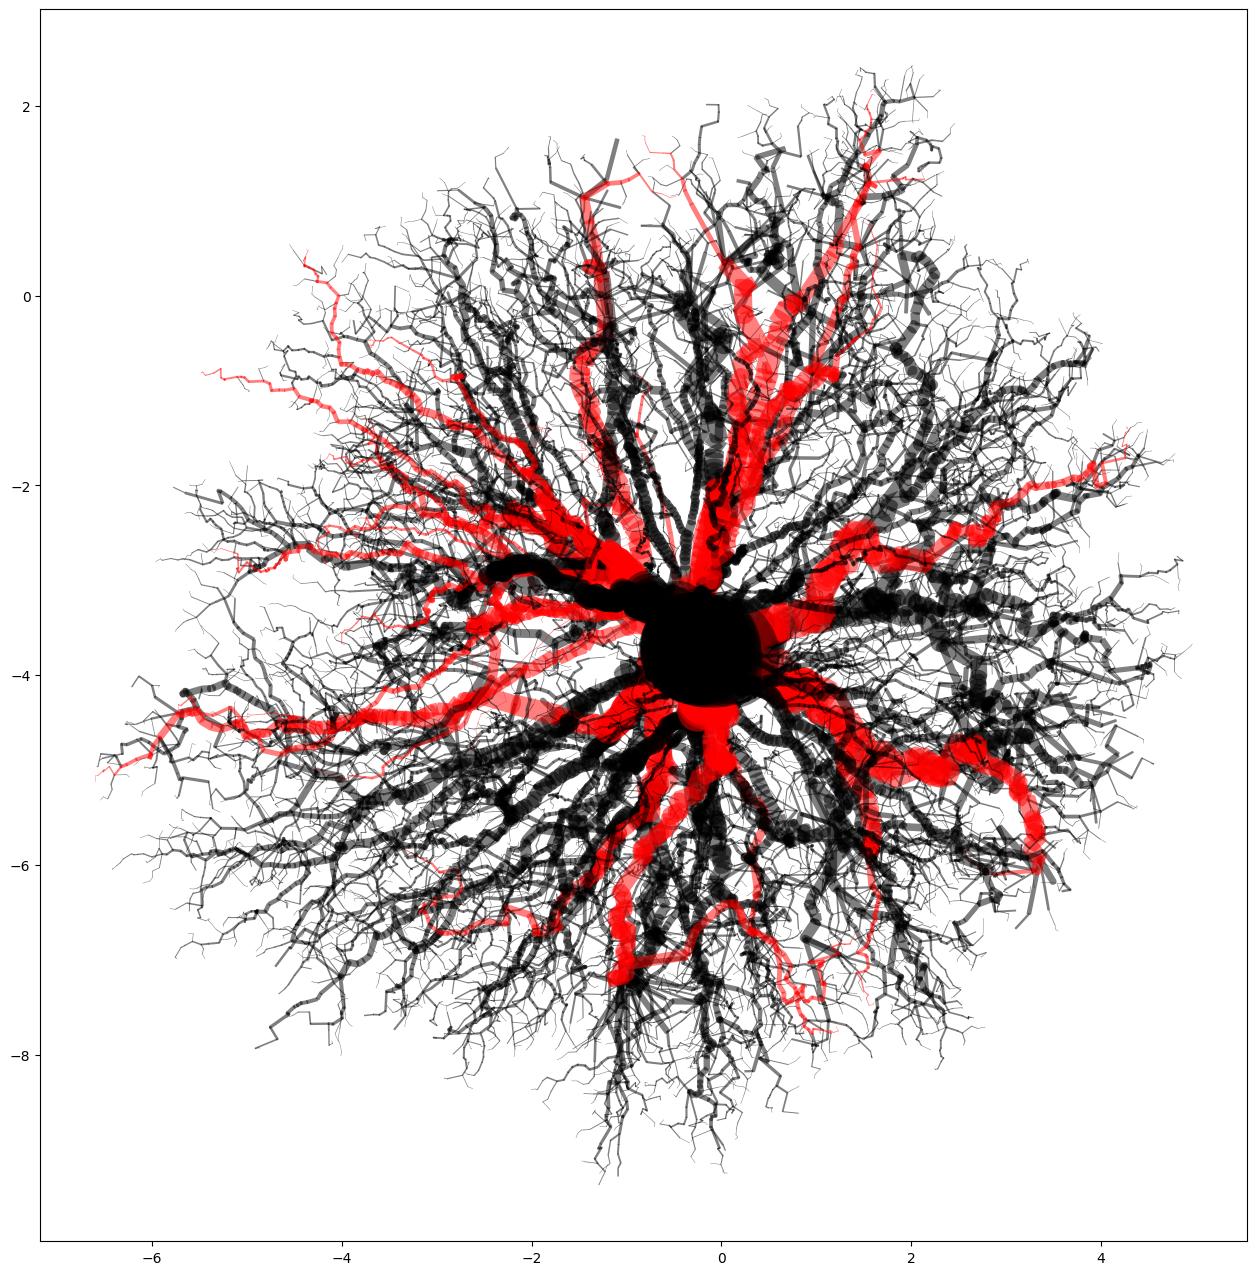

In [184]:
# draw branchs of specified branch order
trunk_ids = []
colors = ['']*len(c.pSV)
polys = []
rev_polys =['']*len(c.pSV)


for idx, bo in enumerate(c.BO):
    if bo == 1: 
        trunk_ids.append(idx)
        colors[-idx] = 'Red'
        #polys.append(c.pSV[idx])
    else:
        colors[-idx] ='None'
    rev_polys[-idx] = c.pSV[idx]

#myPolys = geo.GeoSeries(polys)
#myPolys.plot(color='red')

fig, ax = plt.subplots(figsize = (20,16)) 
myPolys = geo.GeoSeries(rev_polys)
myPolys.plot(color=colors,ax=ax, alpha = .5)
#myPolys.plot()
plt.savefig(str(c.filename).replace('.csv','') +str("_output.svg"), format='svg', dpi=1200)
        
plt.ion()
plt.show()


In [ ]:
#Identifying trunkNodes
import copy
gr= cyls[0].graph 
gtest = copy.deepcopy(gr)
print(gtest.number_of_nodes())
trunkNodes =  np.where(c.BO == 0)[0]

# pull connected components and create graphs 
#c.create_graph()
c=cyls[0]
gtest = copy.deepcopy(c.graph)
print(nx.number_connected_components(gtest))
gtest.remove_nodes_from(trunkNodes)
print(nx.number_connected_components(gtest))

nt_comps = nx.connected_components(gtest)

compGraphs = [gtest.subgraph(c).copy() for c in nt_comps]

gr= cyls[1].graph 
gtest_xz = copy.deepcopy(gr)
print(gtest_xz.number_of_nodes())
trunkNodes_xz =  np.where(c.BO == 0)[0]

c=cyls[1]
gtest_xz= copy.deepcopy(c.graph)
print(nx.number_connected_components(gtest_xz))
gtest_xz.remove_nodes_from(trunkNodes_xz)
print(nx.number_connected_components(gtest_xz))

nt_comps_xz = nx.connected_components(gtest_xz)

compGraphs_xz = [gtest_xz.subgraph(c).copy() for c in nt_comps_xz]





In [ ]:
cyl = c.generate_sub_cyls(compGraphs[10].nodes)

print(len(cyl.pSV))

In [ ]:
#Finding the unoverlapped area for each comp (Slow)
# c= cyls[0]
# compGraphs =[g for g in compGraphs] # the list of generated subgraphs from our connected components 
# compPolys = []
# for f in compGraphs:
#     polys = []
#     for n in f.nodes:
#         polys.append(c.pSV[n])
# #     compPolys.append(polys)
# exposed_projected_area = []
# total_projected_area = []
# for i,x in enumerate(compPolys):
#     #Combined all other branches (And the trunk) into one shape and compute
#     #the overlap between the two
#     otherPolys = unary_union([unary_union(x) for idx,x in enumerate(compPolys) if idx!=i])
#     currPoly = unary_union(x)
#     currPoly_gs = geo.GeoDataFrame(geometry =  geo.GeoSeries(currPoly))
#     other_gs = geo.GeoDataFrame( geometry = geo.GeoSeries(otherPolys))
#     overlay = geo.overlay(other_gs, currPoly_gs, how= 'intersection')
#     tpa = currPoly_gs.area
#     oa = overlay.area
#     exposed_projected_area.append(tpa-oa)
#     total_projected_area.append(tpa)
    
# print(exposed_projected_area)
    




# #testing code for printing out a single overlap
# otherPolys = unary_union([unary_union(x) for i,x in enumerate(compPolys) if i!=6])

# myPolys_gs = geo.GeoSeries(unary_union(compPolys[6]))
# others_gs = geo.GeoSeries(otherPolys)
# myPolys = geo.GeoDataFrame(geometry = myPolys_gs)

# overlay = geo.overlay(others, myPolys, how= 'intersection')
# print(overlay.area)
# print(myPolys_gs.area)
# print(others_gs.area)

others = geo.GeoDataFrame( geometry = c.pSV)
toClip = geo.GeoDataFrame( geometry = c.pSV[0])

clipped = others.clip(toClip)


# print(len(others))
# print(len(clipped))

# fig, ax = plt.subplots(figsize = (20,16))
# others.plot(ax=ax,alpha=.5)
# clipped.plot(alpha=.5)
# plt.ion()
# plt.show() 

# fig, ax = plt.subplots(figsize = (20,16)) 
# myPolys = geo.GeoSeries(compPolys[6])
# others = geo.GeoSeries(otherPolys)
# others.plot(ax=ax,alpha=.5)
# myPolys.plot(ax=ax,alpha=.5)
 
       
# plt.ion()
# plt.show() 

In [128]:
#Drip point identification
# print(compGraphs[10].nodes)
#testing 
c= cyls[0]
# add to self
#self.connComps = pd.DataFrame(columns=['fNodes','drips', 'flow'] 'len','SA','PA','exposedSA']
#Identifying trunkNodes
import copy
#def get_flows(self):
g =c.graph  
trunkNodes =  np.where(c.BO == 0)[0] +1 #node_id is cyl_id +1   
gtest = copy.deepcopy(g)
#Set attributes used to mark drip point and flows
nx.set_edge_attributes(g, np.nan, 'flowType') 
nx.set_edge_attributes(g, np.nan, 'flowID')
nx.set_edge_attributes(g, np.nan, 'dripNode')
nx.set_node_attributes(g, np.nan, 'isDripPoint')
nx.set_node_attributes(g, np.nan, 'isDividePoint')
get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])  
flows = pd.DataFrame(columns=['cyls','len','sa','pa','esa','as']) 
trunk_flow = pd.DataFrame({'cyls' : 0
                            ,'len' : 0
                            ,'sa' : 0
                            ,'pa' : 0
                            ,'esa': 0
                            ,'as' : 0
                        }, index = [0])
flows = pd.concat([flows, trunk_flow], ignore_index=True)
prev_node = None
trunk_edges = []
for n in trunkNodes:
    if prev_node !=None:
        trunk_edges.append((prev_node,n))
    prev_node = n
for te in trunk_edges:
    g.edges[te]['flowID'] = 0
    g.edges[te]['flowType'] = 'stem'  

non_trunk_edges = [e for e in g.edges(trunkNodes) if e not in trunk_edges]
#print(gtest.number_of_nodes())    
gtest.remove_nodes_from(trunkNodes)  
gtest.add_edges_from(non_trunk_edges)   
#print(nx.number_connected_components(gtest))
titans = [node for node in gtest.nodes if (nx.degree(g,node)!=nx.degree(gtest,node))]
    #Nodes with a parent node in trunk, only 1 per connected component
c.connComps = nx.connected_components(gtest)
compGraphs = [g.subgraph(comp).copy() for comp in c.connComps]
# print(len(compGraphs))
flow_to_drip = { 0:1 }# flow_path_id:node_id
#stem flow is always flow_path_id 0 and has drip point node 1
#the last node in a contributing branch flow is considered a drip point for flow_path_id  stem flow 
# if 1==1:
    # compGraph = compGraphs[16]# for testing
    # test = True
for comp_id,compGraph in enumerate(compGraphs): #suenumerate(c.connComps):
    test = False
    if test : print('comp_id: '+str(comp_id))
    #compGraph = g.bgraph(comp).copy()
    nodes = compGraph.nodes()
    # myPolys = []
    # for n in nodes:
    #     myPolys.append(c.pSV[n-1])
    
    endnodes = [e for e in compGraph.nodes if compGraph.degree(e)==1]
    root =list(set(titans) & set(compGraph.nodes)) #get root of connected component
    if root[0] in endnodes: endnodes.remove(root[0])
    sp = nx.shortest_path(compGraph,target=root[0])
    sp_endNode_paths = [path for path in sp.values() if path[0] in endnodes]
    # stem flow is always id 0
    # print('stem flow added :' + str(flows))
    #arrays we are using are all unit arrays and we want angles with x,y and z ([1,0,0],[0,1,0] and [0,0,1])
    # display(flows)
    for path in sp_endNode_paths:
        # print('path ' + str( path))
        traversedEdges = []
        flow = pd.DataFrame({'cyls' : 0
                                ,'len' : 0
                                ,'sa' : 0
                                ,'pa' : 0
                                ,'esa': 0
                                ,'as' : 0
                            }, index = [0])
        angleSum=0
        angles = [0,0,0]
        prev_angles = [0,0,0]
        current_dp_node = 0
        if test : print(path)
        for idx,n in enumerate(path):  
            if test : print('Entering path Loop ' + str(idx) + ' for node '  + str(n) + ' next node ' + str(path[idx+1])) 
            if test : print('dtf: '+str(flow_to_drip))
            if test : print('next node '  + str(path[idx+1])) 
            if test : print('current_dp_node'  + str(current_dp_node)) 
            node_id = n
            next_node_id  = path[idx+1]
            node = g.nodes[node_id]
            next_node =  g.nodes[next_node_id]
            edge = g.edges[node_id,next_node_id]
            if test : print('edge[''inFlow''] '  + str(edge['inFlow'])) 
            if test : print('edge[''len''] '  + str(edge['length'])) 
            curr_angles = get_angle_array(edge['aV'])
            angleSum += curr_angles.iloc[3]  
            traversedEdges.append((node_id,next_node_id)) # add node to list of nodes in this path 
            flow['cyls']+=1
            flow['len'] +=edge['length']
            flow['sa'] +=2*np.pi*edge['radius']*(edge['radius'] +edge['length'])
            flow['pa'] +=edge['poly'].area
            if test : print('flow: ' + str(flow))
            if test : print('flows: ' + str(flows))
            if idx+2==len(path):
                # print('last run entered')
                #then path[idx+1] is the root node -> edge is last edge
                if current_dp_node!= 0:
                    if edge['inFlow']:
                        #not possible as we would have had to set current_dp_node last loop 
                        # we would onlt do so if this edge had out flow
                        if test : print('Error: Reached last edge and edge has inflow and is in drip path')
                        flows = pd.concat([flows, flow], ignore_index=True)
                        flow_id = len(flows.index)-1
                        if len(path)-path.index(current_dp_node)<=4: 
                            flowType = 'stem'
                        else:
                            flowType = 'drip'
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID'] = flow_id
                            g.edges[traversedEdge]['flowType'] = flowType
                            if test : print(str(traversedEdge) + ' marked ' + 'stem')
                        flow_to_drip[flow_id] =current_dp_node
                        traversedEdges = [] # reset array'
                        current_dp_node = 0
                        flow = pd.DataFrame({'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
                        break
                    #Then we are on a drip path 
                    elif ~edge['inFlow']:
                        #then we do indeed add this last cyl to the drip flow
                        flows = pd.concat([flows, flow], ignore_index=True)
                        flow_id = len(flows.index)-1
                        if len(path)-path.index(current_dp_node)<=4: 
                            flowType = 'stem'
                        else:
                            flowType = 'drip'
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID'] = flow_id
                            g.edges[traversedEdge]['flowType'] = flowType
                            if test : print(str(traversedEdge) + ' marked ' + str(flowType))
                        flow_to_drip[flow_id] =current_dp_node
                        if test : print('path.index(current_dp_node): ' + str(path.index(current_dp_node)))
                        if test : print('pathLen ' + str(len(path)))
                        if test : print('current_dp_node: ' + str(current_dp_node))
                        traversedEdges = [] # reset array'
                        current_dp_node = 0
                        flow = pd.DataFrame({'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
                        if test : print('New drip Flow Created (last node ) ' +str(flow_id))
                        break
                elif edge['inFlow']: #must be the case given current_dp_node ==0
                    # edge contribures to stem flow 
                    if test : print('flow to add: '+str(flow))
                    flows = pd.concat([flows, flow], ignore_index=True)
                    flow_id = len(flows.index)-1
                    for traversedEdge in traversedEdges: 
                        g.edges[traversedEdge]['flowID'] = flow_id
                        g.edges[traversedEdge]['flowType'] = 'stem'
                        if test : print(str(traversedEdge) + 'marked stem')
                    flow_to_drip[flow_id] = next_node_id
                    traversedEdges = [] # reset array'
                    current_dp_node = 0
                    flow = pd.DataFrame({'cyls' : 0
                                ,'len' : 0
                                ,'sa' : 0
                                ,'pa' : 0
                                ,'esa': 0
                                ,'as' : 0
                            }, index = [0])
                    if test : print('New stem flow added ' +str(flow_id))
                    if test : print('flows: ' + str(flows))
                break
            elif idx+2<len(path):
                next_next_node_id = path[idx+2]
                if test : print('next_next_node_id' + str(next_next_node_id)) 
                next_next_node =  g.nodes[next_next_node_id]
                next_edge = g.edges[next_node_id,next_next_node_id]
                next_angles = get_angle_array(next_edge['aV'])
                angle_diffs = curr_angles - next_angles
                severe_angle_change = angle_diffs.iloc[3][0]>(1.5*(math.pi/4) )
                    
                if current_dp_node!=0:
                    if next_edge["inFlow"]:#curr edge is last in flow
                        #add new flow, reset vars
                        next_next_node['isDividePoint'] = True
                        flows = pd.concat([flows, flow], ignore_index=True)
                        flow_id = len(flows.index)-1
                        if len(path)-path.index(current_dp_node)<=4: 
                            flowType = 'stem'
                        else:
                            flowType = 'drip'
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID'] = flow_id
                            g.edges[traversedEdge]['flowType'] = flowType
                            if test : print(str(traversedEdge) + 'marked' + str(flowType))
                        flow_to_drip[flow_id] =current_dp_node
                        next_node['isDripPoint'] = True
                        traversedEdges = [] # reset array'
                        flow = pd.DataFrame({'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
                        current_dp_node = 0
                        if test : print('New drip Flow Created (divide reached) ' +str(next_next_node_id))
                        if test : print('traversedEdge: ' + str(traversedEdge))
                        continue
                        
                    if ~np.isnan(next_edge['flowID']):
                        # we might siphon some flow off from the intercepted path here, but we ignore this possibility for simplicity 
                        if ~next_edge["inFlow"]: 
                            #*****Here we have a drip path stemming off of another drip path
                            #We could go through and reduce the intercepted path (next_edge["flowID"]), and add to this new path 
                            #Instead I assume that the drip points are likely to be close by and that some of the flow from the 
                            #intercepted path is likley to flow to its currently defined drip point anyway
                            #
                            #I only deal with the easy case that the next node is our drip point 
                            if next_node['isDripPoint']:
                                #Add current flow to the intercepted flow and change its drip point
                                flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                                next_node['isDripPoint'] = False
                                flowType = next_edge['flowType']
                            flow_id=next_edge['flowID']
                            if test : print('Reached end of path, drip-drip interception :' +str(next_node_id))
                        else:
                            flows = pd.concat([flows, flow], ignore_index=True)
                            flow_id = len(flows.index)-1
                            flowType = 'drip'
                            if test : print('Reached end of path, drip-flow interception :' +str(next_node_id))
                            if test : print('flows: ' + str(flows))
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID']= flow_id
                            g.edges[traversedEdge]['flowType'] = flowType
                            if test : print(str(traversedEdge) + 'marked' + str(flowType))
                        traversedEdges = []
                        flow_to_drip[flow_id] =current_dp_node
                        current_dp_node=0
                        break
                    #else: #next_edge also in drip path
                        #do nothing
                elif edge["inFlow"]: #edge has in flow - slopes towards tree
                    if severe_angle_change and next_edge["inFlow"]: #\\ next edge also has inflow but a >30% diff in angle 
                        next_node['isDripPoint'] = True 
                        # there is no flow further down the path driping here since next_edge["inFlow"]  = True
                        flows = pd.concat([flows, flow], ignore_index=True)
                        flow_id = len(flows.index)-1
                        if idx+4>=len(path): 
                            flowType = 'stem'
                        else :
                            flowType = 'drip'
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID'] = flow_id
                            g.edges[traversedEdge]['flowType'] = flowType
                            if test : print(str(traversedEdge) + 'marked ' + str(flowType))
                        flow_to_drip[flow_id] =next_node_id
                        traversedEdges = [] # reset array'
                        flow = pd.DataFrame({'cyls' : 0
                                    ,'len' : 0
                                    ,'sa' : 0
                                    ,'pa' : 0
                                    ,'esa': 0
                                    ,'as' : 0
                                }, index = [0])
                        if test : print('dtf: '+str(flow_to_drip))
                        if test : print('New drip Flow Created (severe angle change):' +str(flow_id))
                        if test : print('flows: ' + str(flows))
                        continue
                    elif ~np.isnan(next_edge['flowID']):
                        #next_node is already in a flow
                        #add our current flow to this flow - reached end of path
                        if test : print('adding flow params to flow id :' + str(next_edge['flowID']))
                        if test : print('for path :' + str(path))

                        flows.iloc[next_edge['flowID']] = flows.iloc[next_edge['flowID']] + flow.iloc[0]
                        for traversedEdge in traversedEdges: 
                            g.edges[traversedEdge]['flowID'] = next_edge['flowID']
                            g.edges[traversedEdge]['flowType'] = next_edge['flowType']
                            if test : print(str(traversedEdge) + 'marked' + str(next_edge['flowType']))
                        traversedEdges = []
                        #flow_to_drip[flow_id] =current_dp_node # we woul have set the drip point for this flow 
                        if test : print('Reached end of path (inflow):' +str(next_node_id))
                        if test : print('flows: ' + str(flows))
                        break
                    elif ~next_edge["inFlow"]: #\/
                        next_node['isDripPoint'] = True
                        current_dp_node = next_node_id 
                        if test : print('Drip Point Marked (v):' +str(next_node_id))
                        continue
                elif ~edge["inFlow"]:#/, 
                    #we have that current_dp_node==0
                    #if previous edge had in flow, then we would have set current_Dp_node and wouldnt reach this so 
                    # this is either an end node or previous edge had out flow
                    #we then have a chain of out flows until we eventually
                        # reach an inflow (where dp node was set)or
                        # we have a leaf/endnode, in which case that end node was set as dp node by the below 
                    if idx ==0: # we are on and end node 
                        node['isDripPoint'] = True
                        current_dp_node = node_id
                        if test : print('Drip Point Marked (first node):' +str(node_id))
                        continue
                    #else: Continue on as either the row started with an out flow (above case), or it was preceeded by some in flow and we a;ready marked current_dp_node                                        

C:\Users\wisch\AppData\Local\Temp\ipykernel_8960\1346819185.py:19: RuntimeWarning: invalid value encountered in double_scalars
  get_angle_array = lambda v :  pd.DataFrame([np.arccos(v[0]),np.arccos(v[1]),np.arccos(v[2]),np.arccos((v[0]*v[0] + v[1]*v[1])/math.sqrt((v[0]*v[0] + v[1]*v[1])))])


99.0
-132.0
4.950679
-6.593164
231.0
-187.0
48.0
2.402838
-9.372616
235.0


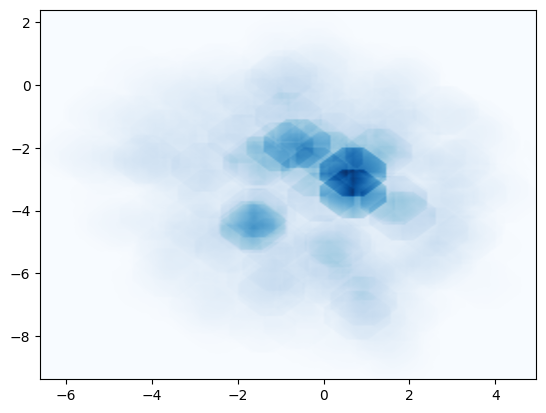

In [217]:
#Map drip points 
#we want to create a x by y matrix where each value represents the x,y location of our node 
#node 1 is at the begining x for cyl1
# given node is at the x1 value for the cyl of its id 
# for each drip node,add to drip_locs the sum of the volume of branches draining at the node
#how to achieve
#itter over nodes 
# bin the locations of the nodes into whole number areas defined by first to decimal pts
#filter dict each time for the flow ids that drip to that node 
#create sA_sum var to add the sa values for each of those flows to 
#add the sa_sum var to the drip_loc array in the location bin 

nx.set_node_attributes(g, np.nan, 'x_loc')
nx.set_node_attributes(g, np.nan, 'y_loc')
nx.set_node_attributes(g, np.nan, 'bin_x_loc')
nx.set_node_attributes(g, np.nan, 'bin_y_loc')

# # bin the locations of the nodes into whole number areas defined by first to decimal pts
g = cyls[0].graph
c=cyls[0]
bin_min_x=0
bin_min_y=0
bin_max_x=0
bin_max_y=0
min_x=0
min_y=0
max_x=0
max_y=0
for loc_node in g.nodes():
    x= (c.x[0][loc_node])
    y= (c.y[0][loc_node])
    if x<min_x: min_x =x
    if y<min_y: min_y =y
    if x>max_x: max_x =x
    if y>max_y: max_y =y
    g.nodes[loc_node]['x_loc'] = x
    g.nodes[loc_node]['y_loc'] = y
    g.nodes[loc_node]['bin_x_loc'] = round(x*20,0)
    g.nodes[loc_node]['bin_y_loc'] = round(y*20,0)
    #print((g.nodes[loc_node]['x_loc'],g.nodes[loc_node]['y_loc'],g.nodes[loc_node]['z_loc']))
    bin_min_x = round(min_x*20,0)
    bin_min_y = round(min_y*20,0)
    bin_max_x = round(max_x*20,0)
    bin_max_y = round(max_y*20,0)

size_x = bin_max_x - bin_min_x
size_y = bin_max_y - bin_min_y
print(bin_max_x) 
print(bin_min_x)
print(max_x) 
print(min_x) 
print(size_x) 
print(bin_min_y) 
print(bin_max_y) 
print(max_y) 
print(min_y) 
print(size_y) 



drip_loc=np.zeros((int(size_y),int(size_x)))
# for x in drip_loc:
#     for y in x:
#         y = 50
for loc_node in g.nodes():
    if loc_node not in trunkNodes:
        def dict_filter(pair):
            current_node = loc_node
            key, value = pair
            if value == current_node:
                return True
            else:
                return False

        node_flow_sa = 0
        flows_ending_at_node = list(filter(dict_filter,c.flow_to_drip.items()))
        for flow_id,dp_node in flows_ending_at_node:
            node_flow_sa += flows.iloc[flow_id]['sa']
            # print(flows.iloc[flow_id]['sa'])
            # print(dp_node)
        # print(loc_node)
        x_loc = int(g.nodes[loc_node]['bin_x_loc'])
        y_loc = int(g.nodes[loc_node]['bin_y_loc'])
        x_loc = int( x_loc - bin_min_x -1)
        y_loc = int( y_loc - bin_min_y -1)
        scale = -30
        curr_y_scale = scale
        while curr_y_scale <= abs(scale) and y_loc+curr_y_scale < size_y:   
            curr_x_scale = scale 
            while curr_x_scale <= abs(scale) and x_loc+curr_x_scale < size_x:
                if abs(curr_y_scale) + abs(curr_x_scale) <= 20 and abs(curr_x_scale)<16 and abs(curr_y_scale)<16 :
                    drip_loc[y_loc+curr_y_scale,x_loc+curr_x_scale] += node_flow_sa*(abs(scale)-(abs(curr_y_scale) + abs(curr_x_scale)))/abs(scale)
                #print(curr_x_scale,curr_y_scale)
                curr_x_scale =curr_x_scale +1
            curr_y_scale =curr_y_scale +1
   

plt.imshow(drip_loc,interpolation='mitchell', cmap='Blues',aspect='auto',extent =[min_x,max_x,min_y,max_y] )

# print(size_x)
# print(size_y)
# square_shape= size_y
# if size_x>=size_y: square_shape =  size_x



# cnt = 0
# sum=0
# for x in drip_loc:
#     for y in x:
#         if y!= 0: 
#             cnt+=1
#             sum+=y
# print(cnt)
# print(sum/cnt)
# print(sum)

# ids = [1,4,5]
# print(flows.iloc[ids])
# print(flows.iloc[ids].sum())
# print(flows.iloc[ids].sum()['len'])

# for flow in flows.iterrows():
#     print(flow[1])
#     print(flow[1]['sa'])#.loc['len'])



In [ ]:
# identifying components and summarizing 
# display(flows)
print(len(flows.index))
print(g.edges[583,584 ])


# flow.iloc[0] = flow.iloc[0] + flow
# flow.iloc[0] = flow.iloc[0] + flow
# print(flow)

# import copy
# #c.create_graph()
# g=c.graph
# gtest = copy.deepcopy(g)
# print(nx.number_connected_components(gtest))
# gtest.remove_nodes_from(trunkNodes)
# print(nx.number_connected_components(gtest))

# nt_comps = nx.connected_components(gtest)

# compGraphs = [gtest.subgraph(c).copy() for c in nt_comps]

# compSize =[len(cc) for cc in nt_comps]

# for x in compSize:
#     print(x) 
# We have 68 connected components but 67 path groups?
#       must be the sement of length 1
#[1683, 1689, 952, 862, 6415, 2252, 2058, 506, 542, 467, 501, 21, 339, 1, 2984, 682, 59, 2, 2284, 2, 2, 324, 505, 329, 2, 2, 8, 2, 2, 30, 4, 231, 6, 288, 65, 158, 6, 2, 134, 11, 5, 240, 44, 2, 58, 39, 15, 12, 5, 3, 2, 2, 1, 1, 41, 11, 3, 2, 11, 3, 11, 7, 5, 3, 10, 3, 2, 1]


# print(len(compSize))
 
# print(len(sigComp))

# print(pd.DataFrame(compSize).describe())
#                  0
# count    68.000000
# mean    396.382353
# std     973.939178
# min       1.000000
# 25%       2.750000
# 50%      11.000000
# 75%     325.250000
# max    6415.000000
 

In [70]:
print(c.pID[1022])

1021


0
throw(27101, 0)


<Figure size 1000x600 with 0 Axes>

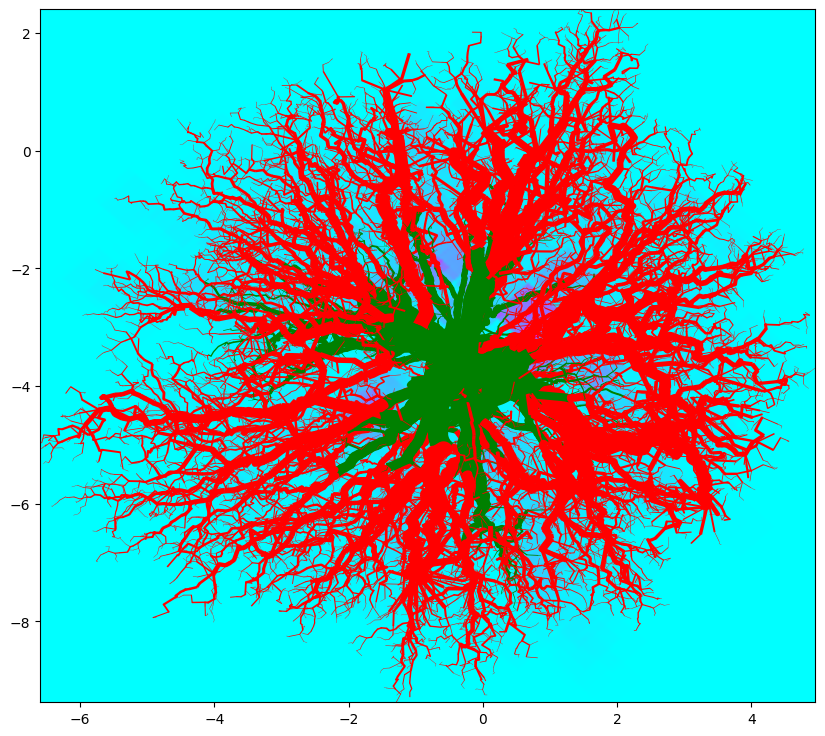

In [167]:
# #Highlighting Drip Branches
# trunk_ids = []
c=cyls[0]
g = c.graph
# colors = ['']*len(c.pSV)
# polys = []
# rev_polys =['']*len(c.pSV)


# for idx,pid in enumerate(c.pID):
#     print(idx,pid)
#     #if pid >-1: print(g.edges[idx,pid])
#     if idx<27101 and g.edges[idx+1,pid+1]['flowType'] == 'drip': 
#         # trunk_ids.append(n2)
#         colors[-idx] = 'red'
#         #polys.append(c.pSV[idx])
#     elif idx<27101 and g.edges[idx+1,pid+1]['flowType'] == '': 
#         colors[-idx] = 'Green'
#     else:
#         colors[-idx] ='None'
#     rev_polys[-idx] = c.pSV[idx]



# #myPolys = geo.GeoSeries(polys)
# #myPolys.plot(color='red')

# fig, ax = plt.subplots(figsize = (20,16))
# myPolys = geo.GeoSeries(rev_polys)
# myPolys.plot(color=colors,ax=ax, alpha = .5)

# plt.savefig(str(c.filename).replace('.csv','') +str("_output.svg"), format='svg', dpi=1200
# c=cyls[1]
# g=cyls[0].graph       
# plt.ion()
# plt.show()
# myPolys = []
# compGraph = compGraphs[27]
# nodes = g.nodes()
# filt_nodes = list(nodes) # [1065, 1064, 1063, 1049, 1048, 1047, 1006, 1005, 1004, 1003, 1002, 1001, 81]
# myColors=[]#['blue']*len(filt_nodes)
# print(filt_nodes[1])

# #filt_nodes = [1065, 1064, 1063, 1049, 1048, 1047, 1006, 1005, 1004, 1003, 1002, 1001, 81]
# for idx,n in enumerate(nodes):
#   if n in filt_nodes: 
#     if idx+1 <= len(filt_nodes): parent = c.pID[n-1]+1
#     if next_node !=0 : 
#       try:
#         if g.edges[parent,n]['flowType'] =='stem': 
#           curr_col ='Green'
#         if g.edges[parent,n]['flowType'] =='drip': 
#           curr_col ='Red'
#       except:
#         print('throw' + str((parent,n)))
#     # print(idx)
#     myColors.append(curr_col)
#     # print(curr_col,(parent,n))
#     myPolys.append(c.pSV[n-1])
#     curr_col ='blue'
# # print(nodes)
# # print(myColors)
# test =geo.GeoSeries(myPolys)
# test.plot(color=myColors,figsize=(15,9))

c=cyls[0]
g=cyls[0].graph       
plt.ion()
plt.show()
myPolys = []
compGraph = compGraphs[27]
nodes = g.nodes()
filt_nodes = list(nodes) # [1065, 1064, 1063, 1049, 1048, 1047, 1006, 1005, 1004, 1003, 1002, 1001, 81]
myColors=[]#['blue']*len(filt_nodes)
print(filt_nodes[1])

#filt_nodes = [1065, 1064, 1063, 1049, 1048, 1047, 1006, 1005, 1004, 1003, 1002, 1001, 81]
for idx,n in enumerate(nodes):
  if n in filt_nodes: 
    if idx+1 <= len(filt_nodes): parent = c.pID[n-1]+1
    if next_node !=0 : 
      try:
        if g.edges[parent,n]['flowType'] =='stem': 
          curr_col ='Green'
        if g.edges[parent,n]['flowType'] =='drip': 
          curr_col ='Red'
      except:
        print('throw' + str((parent,n)))
    # print(idx)
    myColors.append(curr_col)
    # print(curr_col,(parent,n))
    myPolys.append(c.pSV[n-1])
    curr_col ='blue'
# print(nodes)
# print(myColors)
plt.figure(figsize=(10,6))
test =geo.GeoSeries(myPolys)
test.plot(color=myColors,figsize=(10,9))


# for n1,n2,type in compGraph.edges.data('flowType'):
#     print((n1,n2,type))
#     print(g.edges[n1,n2]['flowType'])


# comp 17 is questionable (flow lost due to very slight out flow)
# 23 is questionable but leans the other way towards valididty
# 24 i also questionable outflow over vertical section 
#26 has one questionable branch

plt.imshow(drip_loc,interpolation='mitchell', cmap='cool',aspect='auto',extent =[min_x,max_x,min_y,max_y] )

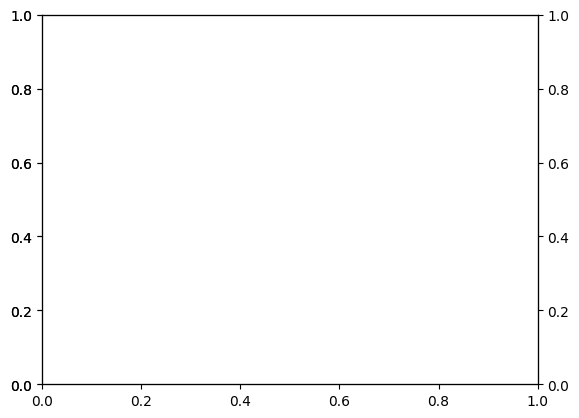

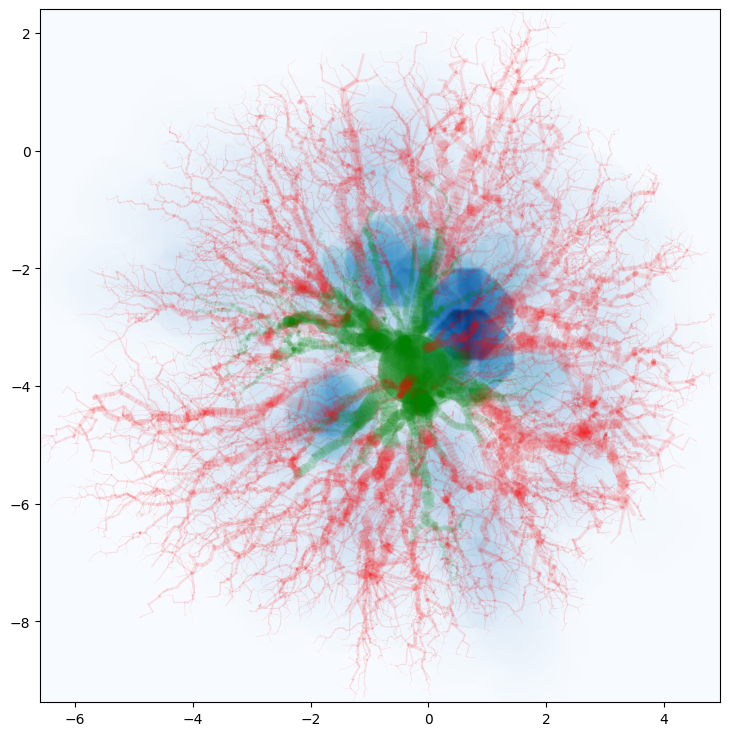

<Figure size 640x480 with 0 Axes>

In [210]:
# myPolys = []
# i=0
# while i<len(c.pSV):
#   myPolys.append(c.pSV[i])
#   i+=1

#myPolys.plot(color=colors,ax=ax, alpha = .5)


fig, ax = plt.subplots()    
# test =geo.GeoSeries(myPolys)
#test.plot(ax=ax,alpha=0.2)
# for row in myColors:
#     if row == 'Green': row = 'lightsteelblue'
#     if row == 'Red': row =='royalblue'
test.plot(color=myColors,figsize=(10,9),alpha=.1)

ax2 = ax.twinx()
ax3 = ax2.twinx()
plt.imshow(drip_loc, cmap='Blues',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y],label='drip')
#plt.imshow(drip_loc_trunk, cmap='Greys',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y] ,label='trunk')

#im1 =ax.imshow(drip_loc, cmap='Reds',interpolation='mitchell',extent =[min_x,max_x,min_y,max_y] )
plt.ion()
plt.show()
plt.savefig(str(c.filename).replace('.csv','') +str('dripMapPlotWStem.svg'), format='svg', dpi=1200)



In [ ]:
#getConnectedComponentNodes
#Goal is to create arrays containing the 


c= cyls[0]
compPolys = []
compNodes = []
totalLengths = []
totalSAs = []
for f in compGraphs:
    polys = []
    nodes = []
    l=0
    r=0
    sa=0
    for n in f.nodes:
        nodes.append(n)
        polys.append(c.pSV[n])
        l +=c.cLength[n]
        r += c.radius[n]
    compPolys.append(polys)
    compNodes.append(n)


    
print(stemPaths[1].attr_dict[1]['length'])

TotalLengths = []
TotalVolume = []
TotalProjectedSurfaceAreas= []
for sp in stemPaths:
    sp.cyls = c
    length,SA,pSA = 0
    for idx, n in enumerate(sp.nodes):
        if idx<len(sp.nodes)-1:
            l =c.cLength[n]
            r = c.radius[n]
            length+=l
            p
            length+=c.cLength[n] 
            print((c.cLength[cylNum],stemPaths[1]))

# for Node n in our path (same as that in graph) 
# cyls.clength[n] = lenghth of nth cylinder
# Also the length of the edge n to n-1 
# 
# if n is in a path, cyl=[n] is in the path for all but last node
    otherPolys = unary_union([unary_union(x) for idx,x in enumerate(compPolys) if idx!=i])
    currPoly = unary_union(x)
    currPoly_gs = geo.GeoDataFrame(geometry =  geo.GeoSeries(currPoly))
    other_gs = geo.GeoDataFrame( geometry = geo.GeoSeries(otherPolys))
    overlay = geo.overlay(other_gs, currPoly_gs, how= 'intersection')
    tpa = currPoly_gs.area
    oa = overlay.area
    exposed_projected_area.append(tpa-oa)
    total_projected_area.append(tpa)



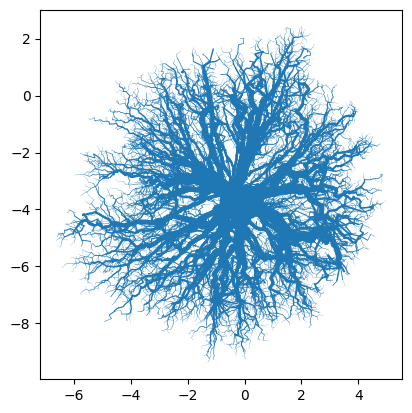

In [113]:
# Draw given component

c= cyls[1]
#add to self
#self.connComps = pd.DataFrame(columns=['fNodes','drips', 'flow'] 'len','SA','PA','exposedSA']
#Identifying trunkNodes
# import copy
# #def get_flows(self):
# g =c.graph   
# trunkNodes =  np.where(c.BO == 0)[0] 
# gtest = copy.deepcopy(g)      
# print(gtest.number_of_nodes())
# trunk_edges = []
# for n in trunkNodes:
#     if prev_node !=None:
#         trunk_edges.append((prev_node,n))
#     prev_node = n 

# non_trunk_edges = [e for e in g.edges(trunkNodes) if e not in trunk_edges]
# #print(gtest.number_of_nodes())    
# gtest.remove_nodes_from(trunkNodes)  
# gtest.add_edges_from(non_trunk_edges)   
# print(nx.number_connected_components(gtest))
# titans = [node for node in gtest.nodes if (nx.degree(g,node)!=nx.degree(gtest,node))]
# #Nodes with a parent node in trunk, only 1 per connected component
# comps_xz = nx.connected_components(gtest)
# compGraphs_xz = [g.subgraph(c).copy() for c in comps_xz]

# c= cyls[1]
# g =c.graph   
# trunkNodes =  np.where(c.BO == 0)[0] 
# gtest = copy.deepcopy(g)      
# print(gtest.number_of_nodes()) 
# trunk_edges = []
# for n in trunkNodes:
#     if prev_node !=None:
#         trunk_edges.append((prev_node,n))
#     prev_node = n

# non_trunk_edges = [e for e in g.edges(trunkNodes) if e not in trunk_edges]
# #print(gtest.number_of_nodes())    
# gtest.remove_nodes_from(trunkNodes)  
# gtest.add_edges_from(non_trunk_edges)        
# print(nx.number_connected_components(gtest))
# titans = [node for node in gtest.nodes if (nx.degree(g,node)!=nx.degree(gtest,node))]
#     #Nodes with a parent node in trunk, only 1 per connected component
# comps = nx.connected_components(gtest)
# compGraphs = [g.subgraph(c).copy() for c in comps]
# # if 1==1:
# # for idx,comp in enumerate(c.connComps):
# #     compGraph = gtest.subgraph(comp).copy()
# compGraph = compGraphs[10]
    
# #draw a connected component

# myPolys = []
# compGraph = compGraphs[comp_id]
# nodes = compGraph.nodes
# print('nodes in compGraph')
# for n in nodes:
#   myPolys.append(cyls[0].pSV[n-1])
# test =geo.GeoSeries(myPolys)
# test.plot()
    
# print(len(nodes))
# print(nodes)
# comp_id = 5
# myPolys_xz= []
# compGraph_xz = compGraphs_xz[comp_id]
# nodes_xz = compGraph_xz.nodes
# print('nodes in compGraph_xz')
# for n in nodes_xz:
#   myPolys_xz.append(cyls[1].pSV[n-1])
# test =geo.GeoSeries(myPolys_xz)
# test.plot()


#list(e for e in g.nodes if g.degree(e)==1)
# identify branchs of various orders
# trunk_ids = []
# colors = ['']*len(c.pSV)
# polys = []
# rev_polys =['']*len(c.pSV)
# for idx, poly in enumerate(c.pSV):
#     if idx in nodes: 
#         colors[-idx] = 'Red'
#     else:
#         colors[-idx] ='None'
#     rev_polys[-idx] = c.pSV[idx]

# #myPolys = geo.GeoSeries(polys)
# # #myPolys.plot(color='red')
# c= cyls[1]
# myPolys = []
# i=75
# # myPolys.append(c.pSV[182])
# # myPolys.append(c.pSV[190])
# # myPolys.append(c.pSV[189])
# myPolys.append(c.pSV[188])
# myPolys.append(c.pSV[187])
# myPolys.append(c.pSV[186])
# myPolys.append(c.pSV[185])
# myPolys.append(c.pSV[184])
# myPolys.append(c.pSV[183])
# myPolys.append(c.pSV[182])
# myPolys.append(c.pSV[127])

# test =geo.GeoSeries(myPolys)
# test.plot()

# # geo.GeoSeries(rev_polys)
c= cyls[1]
# myPolys = []

# myPolys = []
# i=0
# while i<len(c.pSV):
#   myPolys.append(c.pSV[i])
#   i+=1
# test =geo.GeoSeries(myPolys)
# test.plot()
# #myPolys.plot(color=colors,ax=ax, alpha = .5)

#plt.savefig(str(c.filename).replace('.csv','') +str("resr_output.svg"), format='svg', dpi=1200)
        
plt.ion()
plt.show()


In [ ]:

# get_flows
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
#         plt.rcParams["figure.autolayout"] = True
#         gr= self.graph
#         #sp = nx.shortest_path(nx.subgraph(gr,[e for e in gr.nodes if gr.degree(e)==1]),target=0, weight ='get_height')
#         sp = nx.shortest_path(gr,target=0)
#         #print([e for e in gr.nodes if gr.degree(e)==1])
#         endnodes = [e for e in gr.nodes if gr.degree(e)==1]
#         color = iter(cm.rainbow(np.linspace(0, 1, len(endnodes))))
#         #print(len(endnodes))

#         plots =[]
#         fig, ax = plt.subplots()
#         #print(gr.edges[1,0]['attr_dict']['eheight'])
#         for path in sp.values():
#             pathLen = len(path)
#             #x =np.arange(0,pathLen-1)
#             #col = next(color)
#             if (path[0] in endnodes) and pathLen>2:
#                 s = StemPath(self.filename)
#                 s.nodes=path
#                 heights = []
#                 for idx,v in enumerate(path):
#                     if idx+1!=pathLen:
#                         u = path[idx+1]
#                         heights.append( gr.edges[v,u]['attr_dict']['eheight'])
#                 s.heights.append(heights)
#                 self.stemPaths.append(s)
#         for sp in self.stemPaths: 
#             ax.plot(sp.heights, label = str(path[0]))
#         plt.show() 

for v in c.aV:
